In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import MaxPooling2D,Dense,Flatten
from keras.applications import VGG16
import matplotlib.pyplot as plt

In [2]:
root_dir = r"D:\BE\DL\Datasets\caltech-101-img-20251108T052329Z-1-001\caltech-101-img"

In [3]:
#Image Augumentation - this converts your image data into a form ready for the model.Makes smalll modifications.
img_gen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.5,1.0),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3       #30% images go to validation, 70% for training.
) 

In [4]:
#Split data into training and validation subsets.
train_gen = img_gen.flow_from_directory(                  #automatically reads images from subfolders.
    root_dir,            
    target_size=(224,224),            #resizes every image to 224×224 pixels,because VGG16 requires.
    batch_size=32,                   #load 32 images at a time per training step.
    subset='training'
)
val_gen = img_gen.flow_from_directory(
    root_dir,
    target_size =(224,224),
    batch_size=32,
    subset='validation'
)

Found 6445 images belonging to 102 classes.
Found 2700 images belonging to 102 classes.


In [5]:
#Load Pretrained VGG16 Model(VGG16 has 13 conv + 3 dense layers = 16 layers)
base_model = VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
    
)

In [6]:
# Freeze Base Model Layers
#It has already learned low-level features (edges, corners, colors, textures)
#These are general features that apply to almost all kinds of images — whether cats, cars, or airplanes.
#You don’t want to retrain these — they’re already good!
#So, you freeze them and only train your new classifier layers that you added on top.

base_model.trainable = False

In [7]:
#Add Custom Classifier
model = Sequential([
    base_model,
    MaxPooling2D(), #Keeps most imp features only.
    Flatten(),       #converts 3D->1D
    Dense(256,activation='relu'),       #learns task-specific features for your dataset
    Dense(train_gen.num_classes, activation='softmax')  #automatically gives the number of folders (classes) in your dataset.  [cat: 0.70, dog: 0.20, car: 0.10]
])

In [8]:
#Compile and Train the Classifier
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen,validation_data=val_gen,epochs=5)

Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 830s 4s/step - accuracy: 0.5018 - loss: 2.3055 - val_accuracy: 0.6337 - val_loss: 1.4216
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 848s 4s/step - accuracy: 0.7122 - loss: 1.1298 - val_accuracy: 0.7004 - val_loss: 1.1561
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.7832 - loss: 0.8185 - val_accuracy: 0.7433 - val_loss: 0.9481
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 865s 4s/step - accuracy: 0.8242 - loss: 0.6431 - val_accuracy: 0.7756 - val_loss: 0.8214
Epoch 5/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 842s 4s/step - accuracy: 0.8529 - loss: 0.5391 - val_accuracy: 0.7678 - val_loss: 0.8907


In [10]:
#Fine Tune(slightly retraining an already pre-trained model on your new dataset)
base_model.trainable=True
for layer in base_model.layers[:10]:     #freezing only the first 10 layers of the pre-trained model (base_model),and leaving the remaining layers trainable.
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fine_tune_history=model.fit(train_gen,validation_data=val_gen,epochs=5)
     

Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1248s 6s/step - accuracy: 0.0785 - loss: 6.4985 - val_accuracy: 0.0889 - val_loss: 4.4329
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1232s 6s/step - accuracy: 0.0869 - loss: 4.2880 - val_accuracy: 0.0889 - val_loss: 4.1738
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1196s 6s/step - accuracy: 0.0869 - loss: 4.1896 - val_accuracy: 0.0889 - val_loss: 4.1621
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1255s 6s/step - accuracy: 0.0852 - loss: 4.1870 - val_accuracy: 0.0889 - val_loss: 4.1619
Epoch 5/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1289s 6s/step - accuracy: 0.0838 - loss: 4.1861 - val_accuracy: 0.0885 - val_loss: 4.1620


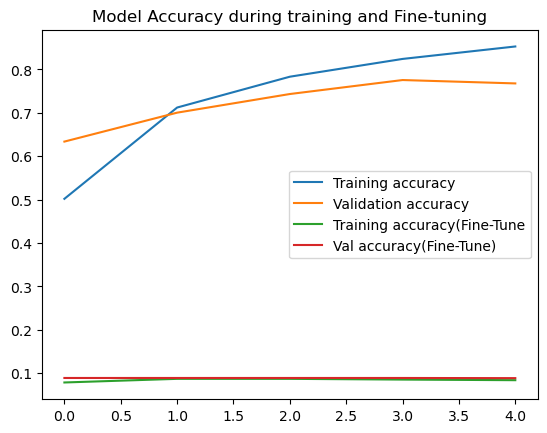

In [12]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Training accuracy(Fine-Tune')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val accuracy(Fine-Tune)')
plt.legend()
plt.title('Model Accuracy during training and Fine-tuning')
plt.show()